# Omniscope/EPIC Hybrid Exploration
## Adam Beardsley
## 10 March, 2020
Full notebook is in the `epic_calculations` repository, in the `notebooks` directory.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import sys
sys.path.append('/home/beards/code/epic_calculations/epic_calculations')
import omni_epic
import imp
imp.reload(omni_epic)
from matplotlib.colors import SymLogNorm
from mpl_toolkits.mplot3d import Axes3D

# Framework

## Cost of an omniscope correlator
Start with a grid defined similarly to Tegmark 2010 (T2010):<br>
$\mathbf{x}_i = \mathcal{O} + P_{i1} \mathbf{a}_1 + P_{i2} \mathbf{a}_2 + \ldots = \mathcal{O} + \sum_{j=1}^{N_v}P_{ij} \mathbf{a}_j$<br>
where $\mathcal{O}$ is an origin reference point, $\mathbf{a}_j$ are vectors that define the size and orientation of the grid levels.
$P_{ij}$ are integers spanning finite ranges: $P_{ij} \in [0, n_j - 1]$. $N_v$ represents the number of vectors describing the grid.

T2010 shows that if antenna positions are fixed to this grid, one can form correlations with $N_v$ convolutions of sizes $n_j$. This can then be rephrased as a set of $N_v$ FFTs.

Worth noting: I'm pretty sure each grid must be zero-padded. So you're actually doing $N_v$ FFTs of sizes $2n_j$.

This may be obvious to people familiar with FFTs, but I had to think it through, so I'm going to write it down.

For each basis vector, we need to do FFTs of length $2n_j$. The cost of one of these FFTs we will say is $2K n_j \log_2(2n_j)$, where $K$ is a constant that encodes the actual number of CMACS (for efficient algorithms, this is about 5/2).

The number of FFTs of this length is equal to<br>
$\frac{\prod_{k=1}^{N_v} 2 n_k}{2 n_j}$.<br>
So the total cost at this level is:<br>
$K \frac{\prod_{k=1}^{N_v} 2 n_k}{2 n_j} \times 2n_j \log_2(2n_j)$

Adding all the levels together, we find the total cost of the $N_v$-dimensional FFT is:<br>
$K\sum_{j=1}^{N_v} \frac{\prod_{k=1}^{N_v} 2 n_k}{2 n_j} \times 2 n_j \log_2(2n_j)$

$= K\sum_{j=1}^{N_v} \prod_{k=1}^{N_v} (2 n_k) \times  \log_2(2n_j)$

$= K\prod_{k=1}^{N_v} (2 n_k)\times \sum_{j=1}^{N_v}   \log_2(2n_j)$

$= K\prod_{k=1}^{N_v} (2 n_k)\times  \log_2(\prod_{j=1}^{N_v} (2 n_j))$

$= K\times 2^{N_v} \times \prod_{k=1}^{N_v} n_k\times  (N_v + \log_2(\prod_{j=1}^{N_v} (n_j))$

We can now replace the product over $n_j$ with $N_a$, the number of antennas, to get to a simplified result:<br>
$= K\times 2^{N_v} \times N_a \times  (N_v + \log_2(N_a))$

This cost function is what I will use to optimize grids below. It has been coded into `omni_epic.omniscope_cost()`.

## Goal: Fit grid to an array

Given an array layout, we want to find a hierarchical grid, as defined above, which "contains" the array (defined below), and has a cost less than the "brute force" method of a single grid (which is a special case of $N_v=1$).

This gets tricky to constrain the problem very quickly, so I will start in 1D.

### Setting up constraints

Start with a 1D grid<br>
$x_i = \mathcal{O} + \sum_{j=1}^{N_v}P_{ij} a_j$

WLOG, let us assume $a_j > 0 \forall j$, and the basis vectors are sorted by length, $a_{j} < a_{j+1}$. We will assume the smallest grid level, $a_1$, is determined by the user as it dictates the field of view of the processed image. Furthermore, while it is not strictly required by the framework, we will assume each grid level is at most half the size of the previous.

We will say an array is contained in a grid if each antenna, plus/minus a radius, is within half the smallest grid basis vector length of a grid point.<br>
$\forall d_j, \exists x_i  s.t. | (d_j \pm r - x_i)|  < \frac{a_1}{2}$<br>
where $d_j$ are the antena locations, and $r$ is the radius of the antennas.

We can imediately see that $\mathcal{O} \le \text{min}(d_j) - r + \frac{a_1}{2}$, and $\mathcal{O} \le \text{min}(d_j) - r + \frac{a_1}{2} - a_{Nv}$ would be simply redundant. This puts a nice constraint on the origin.

While we have put some constraints on the grid, the parameter space is still quite large and discrete - which makes parameter searching difficult.

### Directing the search
From here we must find a strategy to narrow in on a solution. We note that the cost function only depends on the number of levels and the product of $n_j$'s (ie, $N_a$ in the cost calculation above). We will try to find all possible combinations of $n_j$'s which "beat" a brute force cost, then we can search for working grids for each set in order.

First we calculate the brute force grid. This is done by simply setting the origin at the left-most antenna, and adopting a single level grid where $n_1 = \text{ceil}\left((\text{max}(d_j) - \text{min}(d_j)) / a_1 + 1\right)$.

Next we note that due to the padding each level comes at a cost -- in order to "beat" the previous level, we must reduce $N_a$ by a factor of two. 

We next want to find the maximum number of levels we must search.
A grid with $N_{v,\text{max}}$ levels must have at least $2^{N_{v,\text{max}}}$ grid points (a single-point level is meaningless). Next we note that due to the padding, each level comes at a cost -- in order to "beat" the previous level, we must reduce $N_a$ by a factor of two. Consequently, the number of grid points must be less than $n_1$, reduced by a factor of 2 for each level beyond the single level (ie, $n_1 \times 2^{-(N_{v,\text{max}}-1)}$).

$2^{N_{v,\text{max}}} \le n_1 \times 2^{-(N_{v,\text{max}}-1)} \rightarrow N_{v,\text{max}} \le (\log_2(n_1) + 1) / 2$

This allows us to write down a finite number of $n_j$ sets to try, and their associated costs. The calculation is done in `omni_epic.array1D.get_candidate_njs()`.

We can further reduce candidates by requiring total number of grid points >= number of antennas. This option is controlled in the above function with the keyword `force_ng_gt_na`, which is `True` by default. Annecdotally I've found this to save about half the computing time.

## Searching parameter space
We proceed to step through the $n_j$ sets, starting with the lowest cost and stepping up. Once we find a set which can produce a valid grid, we are done and have optimized the grid.

With a given set of $n_j$'s, our parameter space is reduced to $\{\mathcal{O}, a_1, \ldots a_{N_v-1}\}$. 

We will generate a random grid by selecting random numbers from 0 to 1, and mapping those to physical values according to the constraints described above (see `omni_epic._rand2physical()`). We then test whether the array is contained in the grid -- if so, we are done; if not, we will assign a "score" which will help us find a solution.

### Score
I'm highlighting this because it's probably something we want to revisit. We assign a score to the grid by finding all antennas which are not contained. We then sum together the shortest distances between each of these antennas and their nearest grid point. The hope here is that this will establish a gradient in parameter space which will lead a search algorithm to a solution where all antennas are contained (which will have a score of zero).

Armed with a way of generating arrays and scoring them, we implement a simple minimization routine (`scipy.optimize.minimize()`) to get our best score (preferably zero). The actual function that gets minimized is `omni_epic.func_to_min()`. The function that puts all this together is `omni_epic.find_grid()`.

# Testing it out

In [2]:
# Some simple example arrays that cluster well
np.random.seed(0)
grid1 = 200.
n1 = 6
grid2 = 6.
n2 = 10
randsize = 1.
labels = []
arrays = []

locs = []
for i in range(n1):
    for j in range(n2):
        locs.append(grid1 * i + grid2 * j)
arrays.append(omni_epic.array1D(locs))
labels.append('2lvl_no_rand')

locs = []
for i in range(n1):
    for j in range(n2):
        locs.append(grid1 * i + grid2 * j + randsize * np.random.randn())
arrays.append(omni_epic.array1D(locs))
labels.append('2lvl_rand')

grid1 = 200.
n1 = 6
grid2 = 50.
n2 = 3
grid3 = 1.
n3 = 5

locs = []
for i in range(n1):
    for j in range(n2):
        for k in range(n3):
            locs.append(grid1 * i + grid2 * j + grid3 * k)
arrays.append(omni_epic.array1D(locs))
labels.append('3lvl_no_rand')

locs = []
for i in range(n1):
    for j in range(n2):
        for k in range(n3):
            locs.append(grid1 * i + grid2 * j + grid3 * k + randsize * np.random.randn())
arrays.append(omni_epic.array1D(locs))
labels.append('3lvl_rand')

grid1 = 1000.
n1 = 6
grid2 = 50.
n2 = 3
grid3 = 1.
n3 = 5

locs = []
for i in range(n1):
    for j in range(n2):
        for k in range(n3):
            locs.append(grid1 * i + grid2 * j + grid3 * k)
arrays.append(omni_epic.array1D(locs))
labels.append('3lvl_large')

# And one that does not cluster well
arrays.append(omni_epic.array1D(200 * np.random.randn(90) + 500.))
labels.append('Random')

<IPython.core.display.Javascript object>


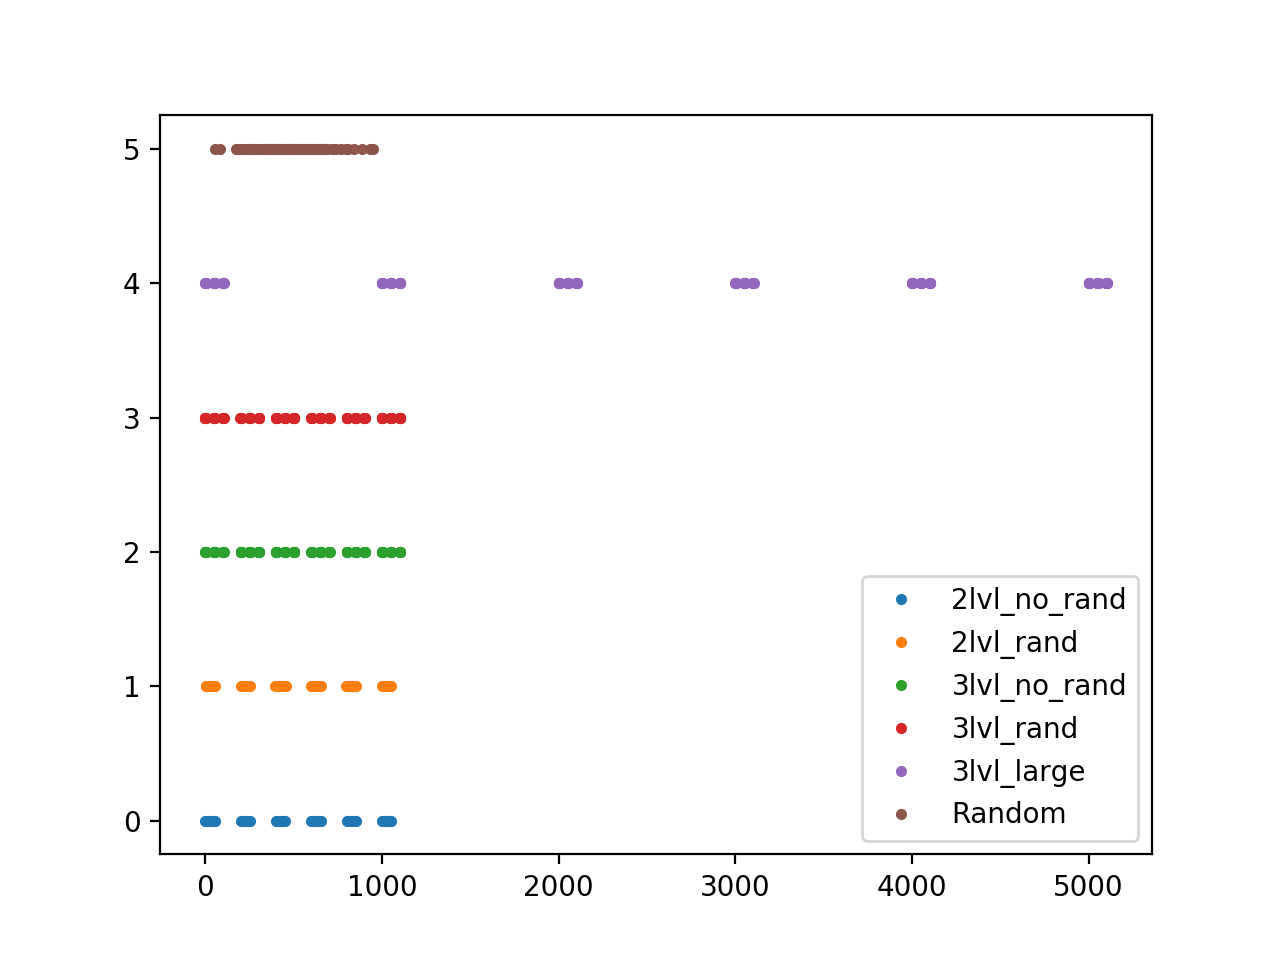

In [20]:
# Plot my test arrays
plt.figure()
for i in range(len(arrays)):
    plt.plot(arrays[i].ant_locs, i * np.ones(len(arrays[i].ant_locs)), '.', label=labels[i])
plt.legend()

In [4]:
psfs = [arr.psf(fov=1, res=1e-4) for arr in arrays]

<IPython.core.display.Javascript object>


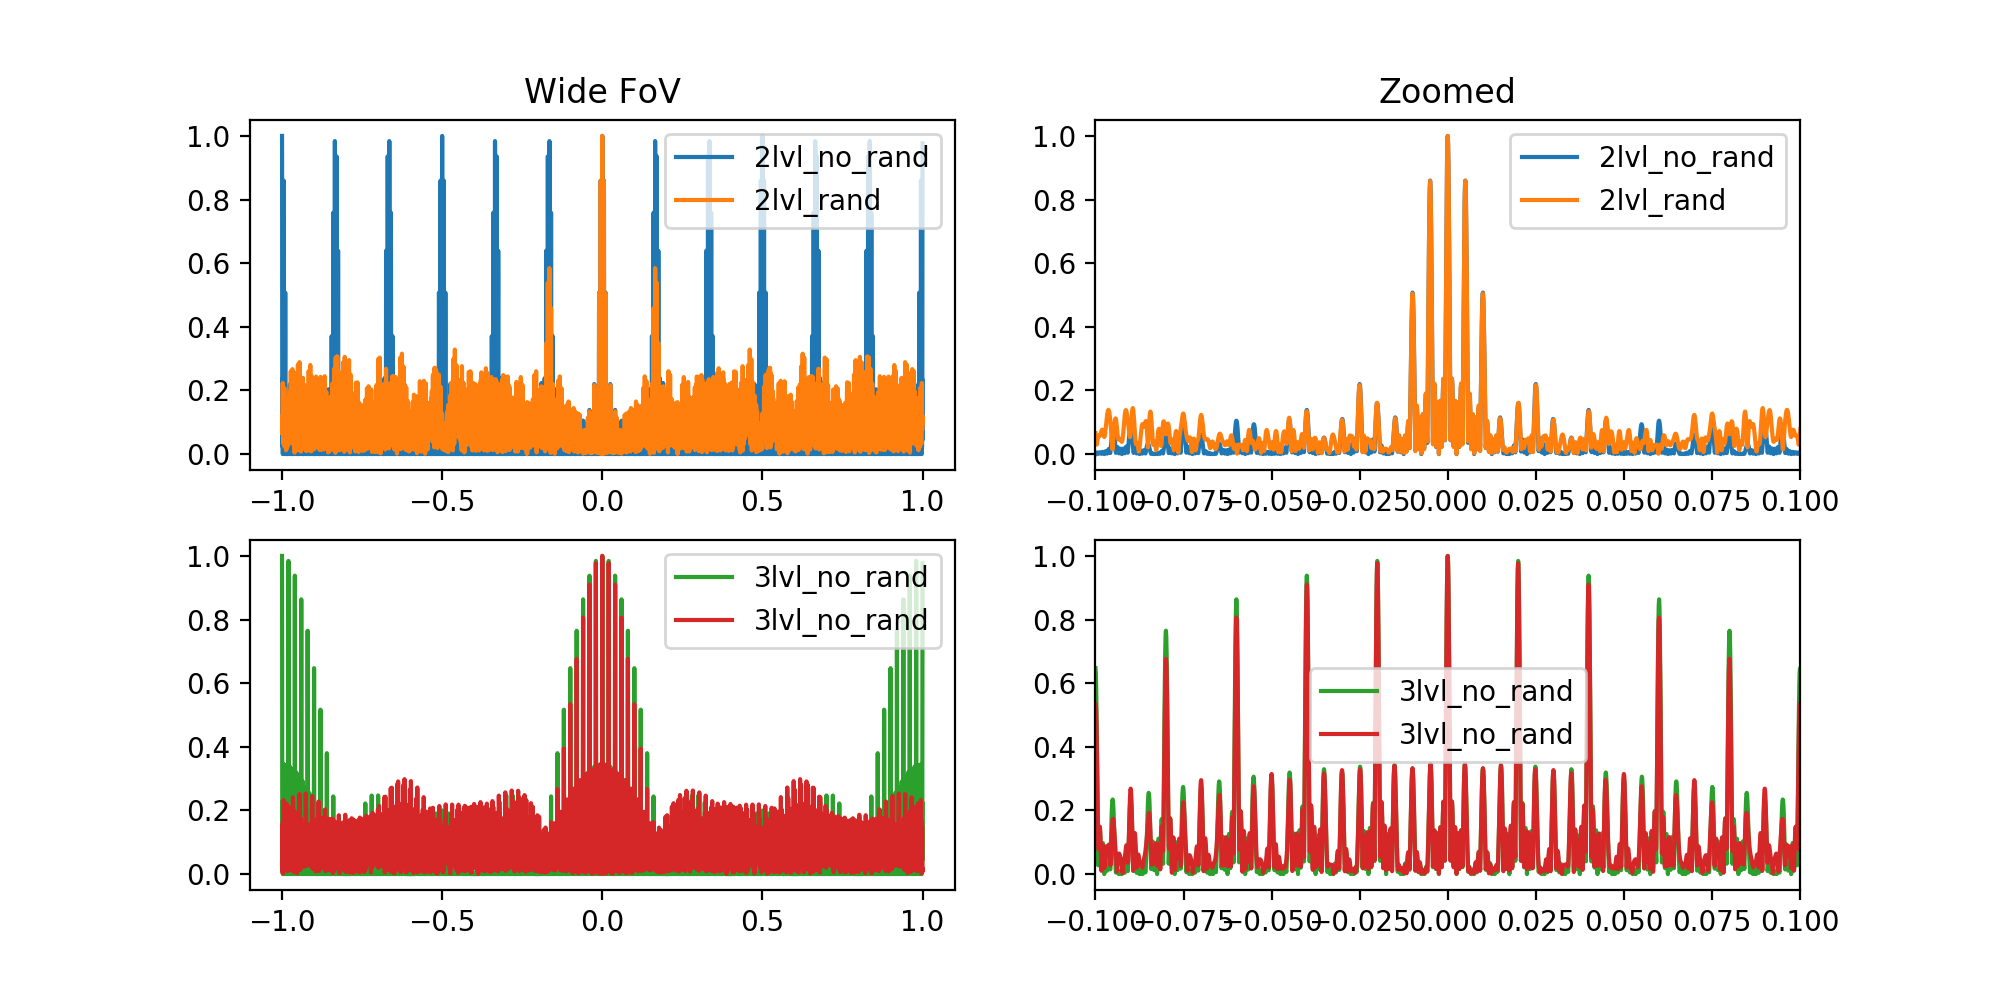

In [21]:
# Have a look at the PSFs
plt.figure(figsize=(10, 5))

plt.subplot(221)
for i, (angles, psf) in enumerate(psfs[0:2]):
    plt.plot(angles, psf, label=labels[i])
plt.legend()
plt.title('Wide FoV')

plt.subplot(222)
for i, (angles, psf) in enumerate(psfs[0:2]):
    plt.plot(angles, psf, label=labels[i])
plt.xlim([-.1, .1])
plt.legend()
plt.title('Zoomed')

plt.subplot(223)
plt.plot(psfs[2][0], psfs[2][1], label=labels[2], color='C2')
plt.plot(psfs[3][0], psfs[3][1], label=labels[2], color='C3')
plt.legend()

plt.subplot(224)
plt.plot(psfs[2][0], psfs[2][1], label=labels[2], color='C2')
plt.plot(psfs[3][0], psfs[3][1], label=labels[2], color='C3')
plt.xlim([-.1, .1])
plt.legend()

Note that the random jitter is only introduced at the scale of the smallest grid spacing. So the widest grating lobes are surpressed. One could further reduce the smaller grating lobes by introducing jitter at larger array scales. To do.

In [6]:
# Let's make sure we can recover the simple 2D regular grid:
ogrid = omni_epic.find_grid(arrays[0], amin=6)  # 6 is the actual smallest separation
print(ogrid.res)
ogrid2 = omni_epic.find_grid(arrays[0], amin=2.5)  # A different smallest grid
print(ogrid.res)

      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 3
   status: 0
  success: True
        x: array([0.01050796, 0.94832627])
      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 3
   status: 0
  success: True
        x: array([0.01050796, 0.94832627])


<IPython.core.display.Javascript object>


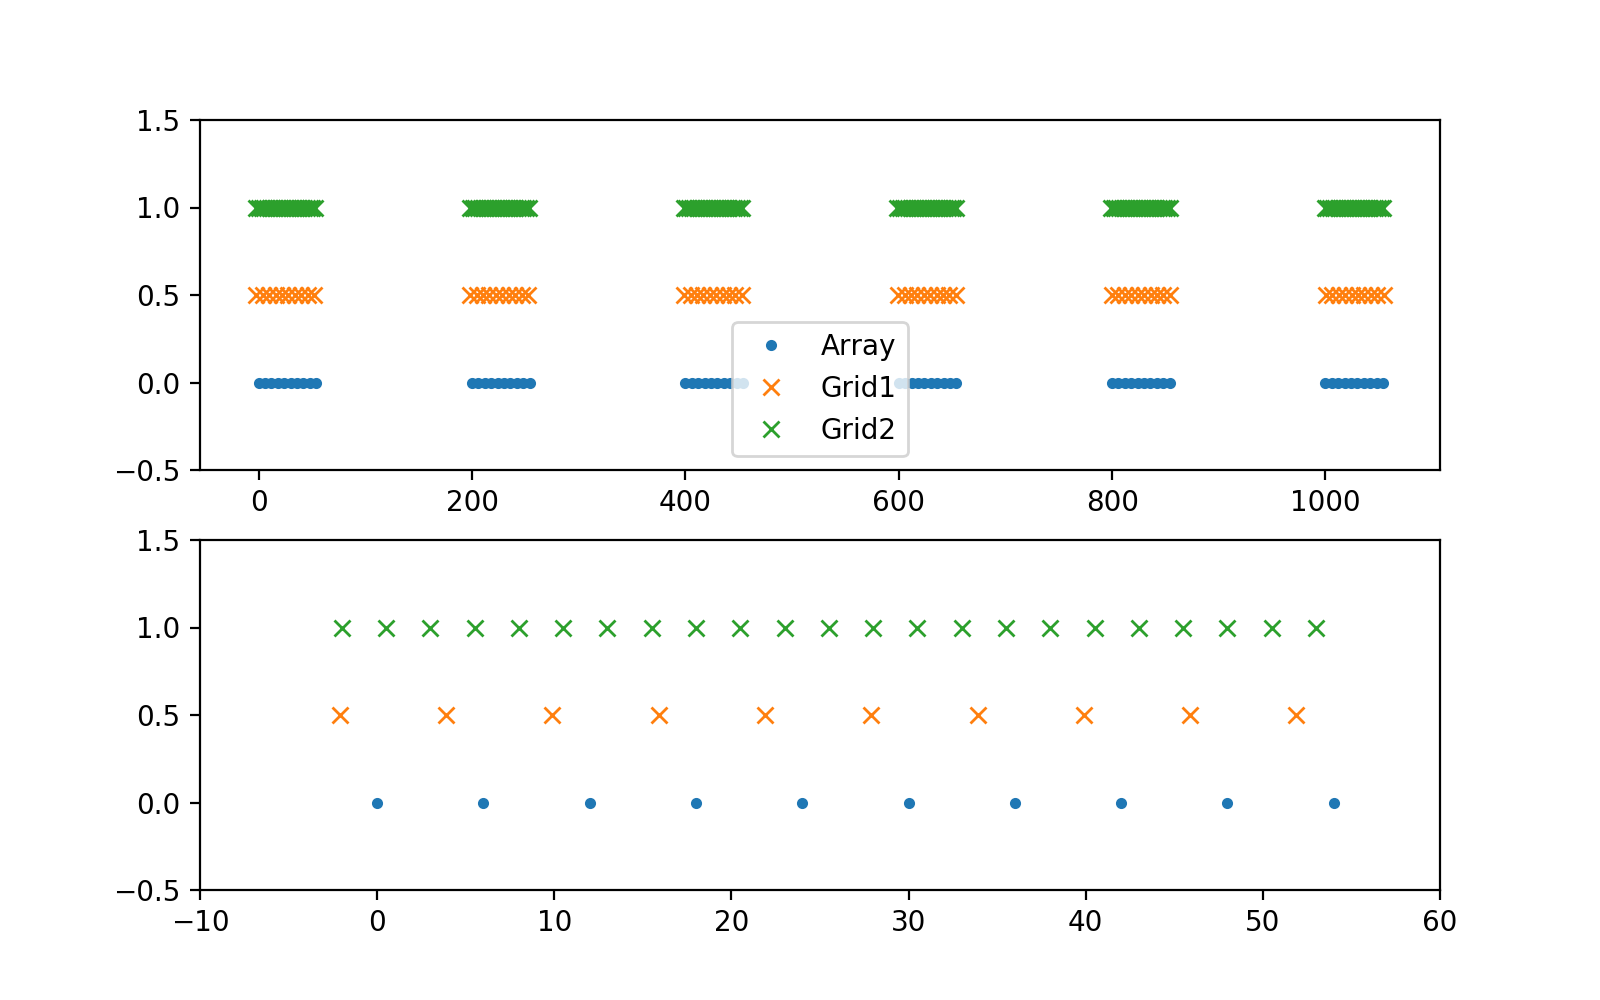

(-10, 60)

In [22]:
# Plot the results -- full, and zoomed in on one grouping
plt.figure(figsize=(8, 5))
plt.subplot(211)
plt.plot(ogrid.array.ant_locs, np.zeros_like(ogrid.array.ant_locs), '.', label='Array')
plt.plot(ogrid.grid.grid, .5 * np.ones_like(ogrid.grid.grid), 'x', label='Grid1')
plt.plot(ogrid2.grid.grid, np.ones_like(ogrid2.grid.grid), 'x', label='Grid2')
plt.ylim([-.5, 1.5])
plt.legend()

plt.subplot(212)
plt.plot(ogrid.array.ant_locs, np.zeros_like(ogrid.array.ant_locs), '.', label='Array')
plt.plot(ogrid.grid.grid, .5 * np.ones_like(ogrid.grid.grid), 'x', label='Grid1')
plt.plot(ogrid2.grid.grid, np.ones_like(ogrid2.grid.grid), 'x', label='Grid2')
plt.ylim([-.5, 1.5])
plt.xlim([-10, 60])

In [8]:
# Now let's run it on all of them (this takes a while)
ogrids = []
for i in range(len(arrays)):
    print(labels[i])
    ogrids.append(omni_epic.find_grid(arrays[i], amin=3.))
    print(ogrids[-1].res)
    print('\n')

2lvl_no_rand
      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 4
   status: 0
  success: True
        x: array([0.00694891, 0.94951145])


2lvl_rand
      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 4
   status: 0
  success: True
        x: array([0.01123923, 0.94727876])


3lvl_no_rand
      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 2
   status: 0
  success: True
        x: array([9.78845361e-05, 9.96025294e-01])


3lvl_rand
      fun: 0.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'

<IPython.core.display.Javascript object>


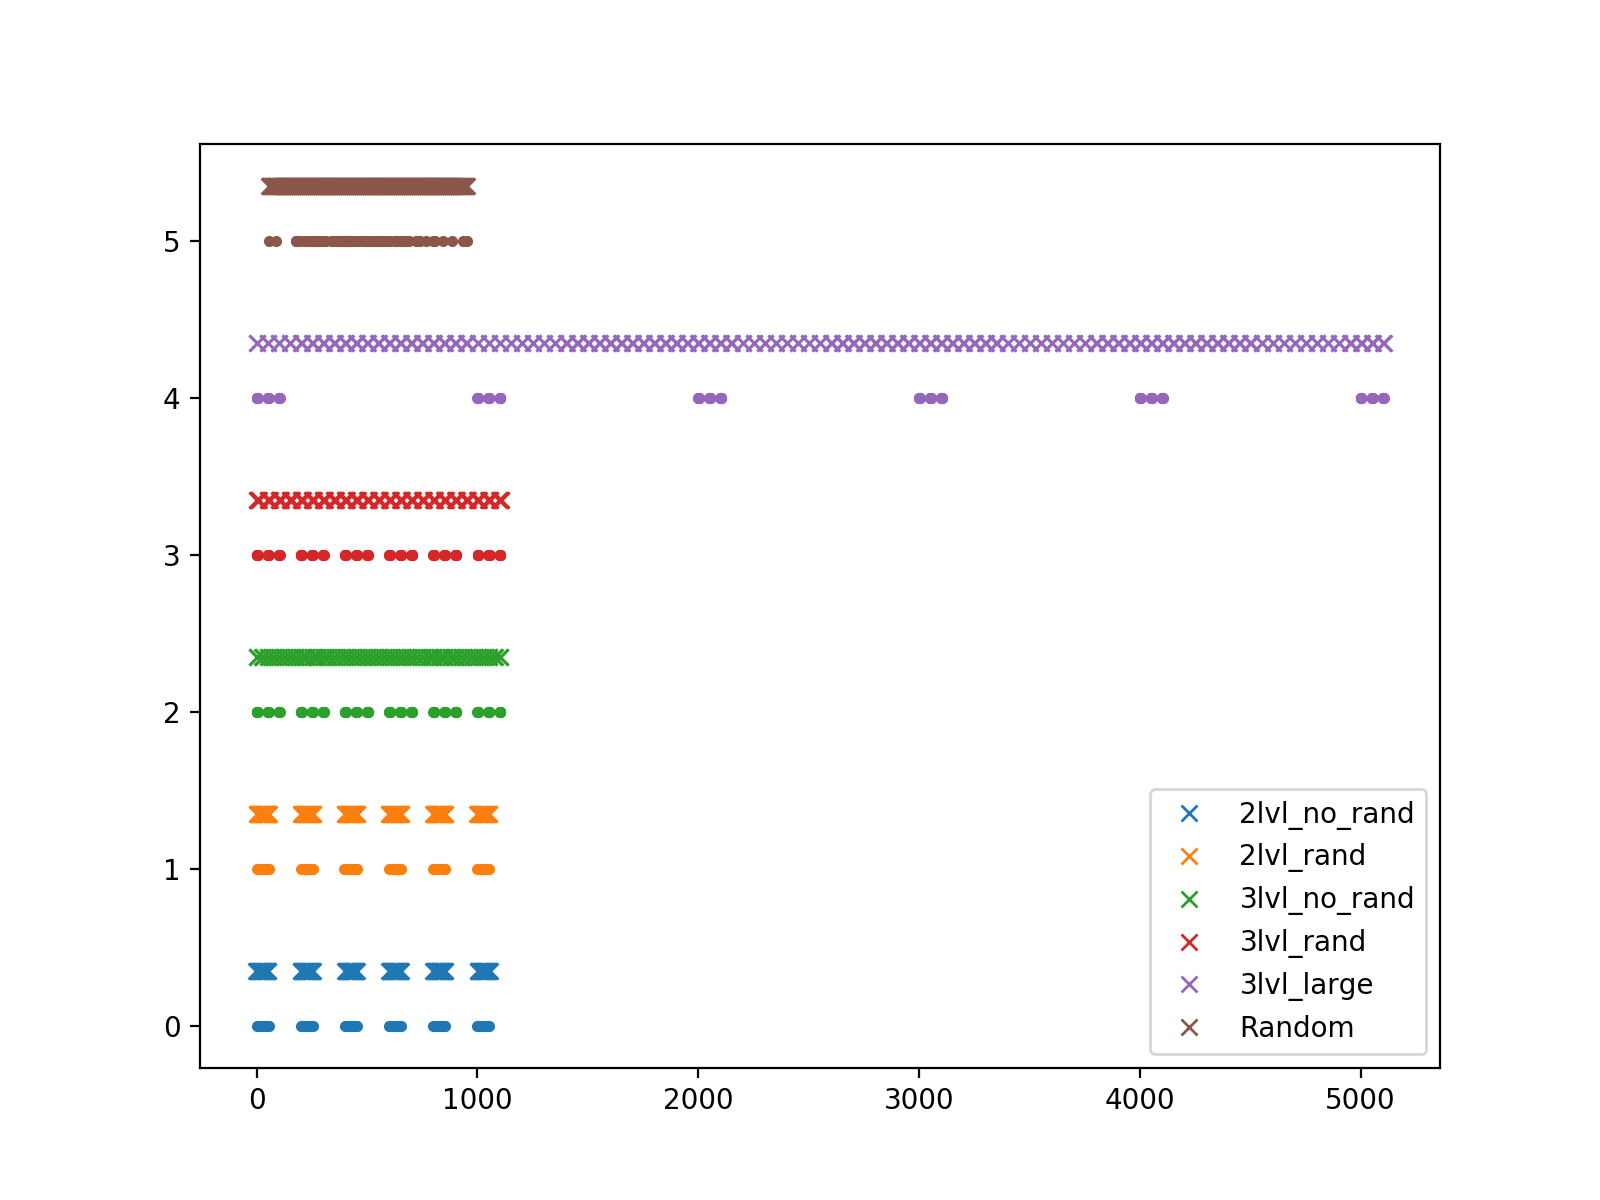

In [23]:
# Have a look at all the arrays
plt.figure(figsize=(8, 6))
for i in range(len(ogrids)):
    plt.plot(ogrids[i].array.ant_locs, i + np.zeros_like(ogrids[i].array.ant_locs), '.', color='C' + str(i))
    plt.plot(ogrids[i].grid.grid, i + .35 * np.ones_like(ogrids[i].grid.grid), 'x', color='C' + str(i), label=labels[i])
plt.legend()

<IPython.core.display.Javascript object>


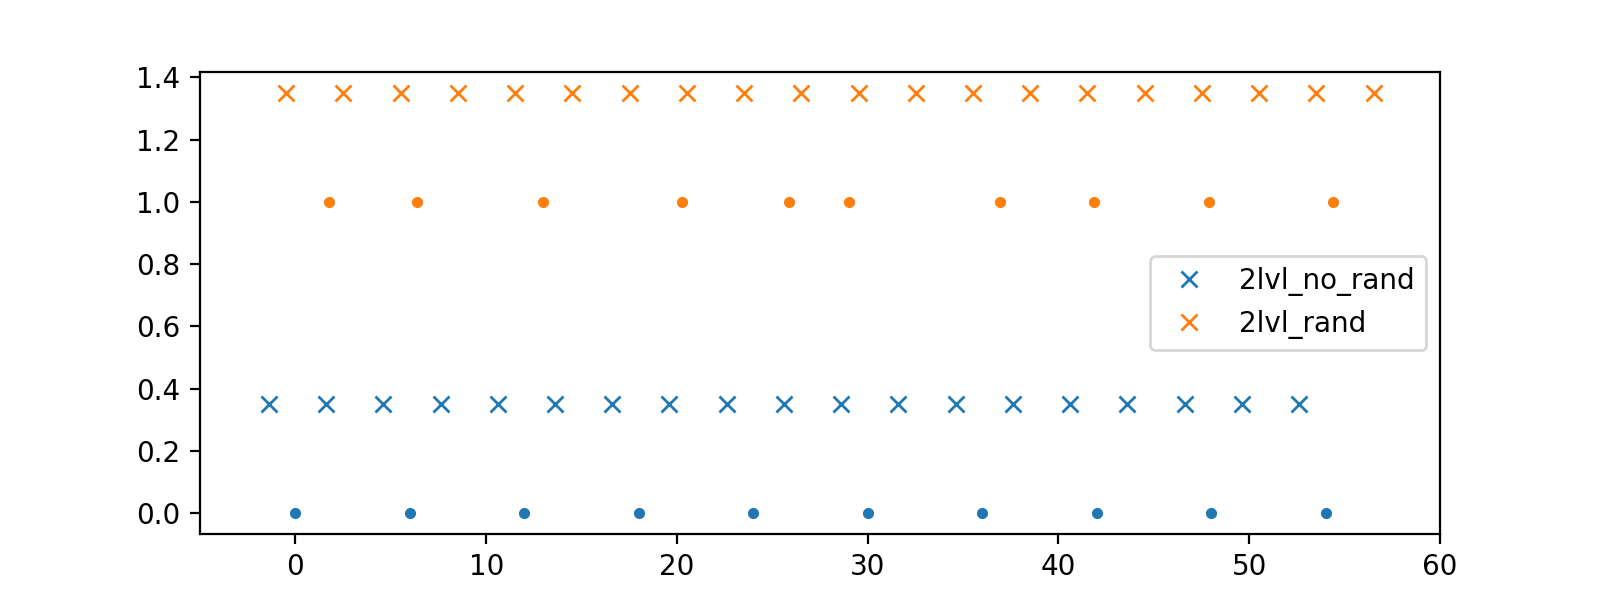

(-5, 60)

In [24]:
# Close up on two-level arrays
plt.figure(figsize=(8, 3))
for i in range(2):
    plt.plot(ogrids[i].array.ant_locs, i + np.zeros_like(ogrids[i].array.ant_locs), '.', color='C' + str(i))
    plt.plot(ogrids[i].grid.grid, i + .35 * np.ones_like(ogrids[i].grid.grid), 'x', color='C' + str(i), label=labels[i])
plt.legend()
plt.xlim([-5, 60])

<IPython.core.display.Javascript object>


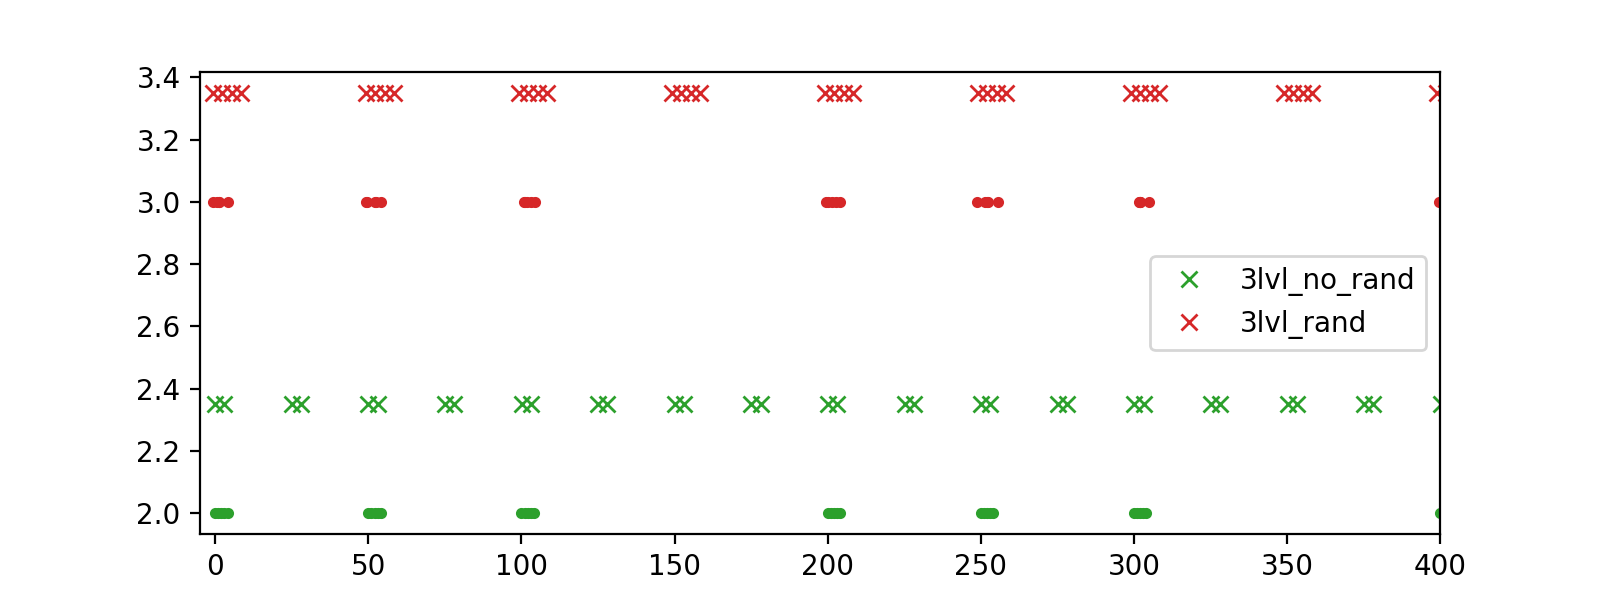

(-5, 400)

In [25]:
# Close up on three-level arrays
plt.figure(figsize=(8, 3))
for i in range(2, 4):
    plt.plot(ogrids[i].array.ant_locs, i + np.zeros_like(ogrids[i].array.ant_locs), '.', color='C' + str(i))
    plt.plot(ogrids[i].grid.grid, i + .35 * np.ones_like(ogrids[i].grid.grid), 'x', color='C' + str(i), label=labels[i])
plt.legend()
plt.xlim([-5, 400])

It looks like the two level grid was solved for without too much issue. But we're getting two level grids for the three level arrays. Hmm..

In [12]:
# Why are we never getting a 3-level solution?
# Look at first 3-level array
arri = 2
print('njs ' + str(ogrids[arri].grid.njs))
njs, costs = arrays[arri].get_candidate_njs(amin=3., reorder=True)
# Given this amin, correct answer should be [2, 3, 6]
njs_correct = [2, 3, 6]
print([cost for nj, cost in zip(njs, costs) if nj == njs_correct])
print([cost for nj, cost in zip(njs, costs) if nj == ogrids[arri].grid.njs])

njs [2, 45]
[]
[7642.667786696707]


### "Correct" Grid is not always more efficient.
Because of the padding, each level comes at a cost. If the savings in computation doesn't make up for the additional padding, you don't gain anything. One way to look at it is that one level to the next should have a filling factor < 1/2.

Ok, so why isn't the larger 3-level array working?

In [13]:
# Narrow in on the large 3-level array
arri = 4
print('njs ' + str(ogrids[arri].grid.njs))
njs, costs = arrays[arri].get_candidate_njs(amin=3., reorder=True)
# Given this amin, correct answer should be [2, 3, 6]
njs_correct = [2, 3, 6]
print([cost for nj, cost in zip(njs, costs) if nj == njs_correct])
print([cost for nj, cost in zip(njs, costs) if nj == ogrids[arri].grid.njs])

njs [2, 103]
[]
[19954.19108599743]


In [14]:
# Try manually making the grid
# Correct basis vectors should be [3, 50, 1000]
params = [0., .08725, .977415]
amin = 3.
amax = arrays[arri].bl_max / (njs_correct[-1] - 1)  # TODO: make smarter
omax = np.min(arrays[arri].ant_locs)
origin, basis_vecs = omni_epic._rand2physical(params, omax, amin, amax)
print(origin, basis_vecs)
this_grid = omni_epic.HierarchicalGrid_1D(basis_vecs, njs_correct, origin=origin)
score = this_grid.grid_vs_array_score(arrays[arri], mindist=None, radius=0)
print(score)
# score it with the func_to_min
score = omni_epic.func_to_min(params, arrays[arri], njs_correct, amin=amin, mindist=None, radius=0)
print(score)

# Ok, try minimize function
res = omni_epic.minimize(omni_epic.func_to_min, np.zeros(len(njs_correct)),
                         args=(arrays[arri], njs_correct, amin, None, 0),
                         bounds=[(0, 1) for i in range(len(njs_correct))])
print(res, '\n')
# Try giving it the right answer for the seed
res = omni_epic.minimize(omni_epic.func_to_min, [0., .08725, .977415],
                         args=(arrays[arri], njs_correct, amin, None, 0),
                         bounds=[(0, 1) for i in range(len(njs_correct))])
print(res)

0.0 [   3.           50.0089     1000.00413401]
0.0
0.0
      fun: 3842.500003480701
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   324.65777622, -30263.99808732,      0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 164
      nit: 6
   status: 0
  success: True
        x: array([0.00146943, 1.        , 1.        ]) 

      fun: 0.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
   status: 0
  success: True
        x: array([0.      , 0.08725 , 0.977415])


<IPython.core.display.Javascript object>


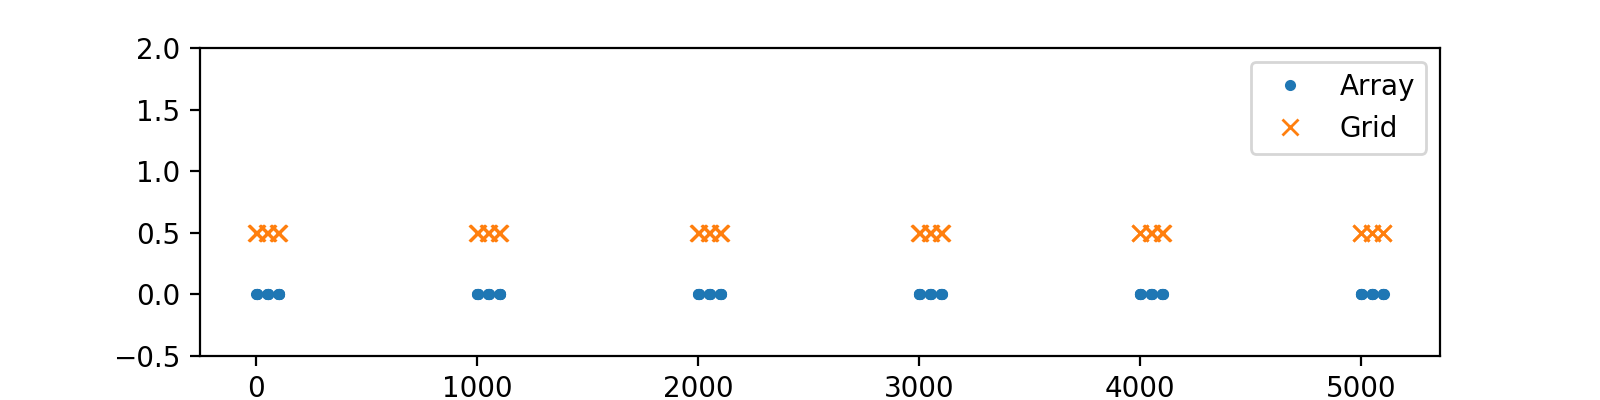

In [26]:
# Plot the correct solution
plt.figure(figsize=(8, 2))
plt.plot(arrays[arri].ant_locs, np.zeros_like(arrays[arri].ant_locs), '.', label='Array')
plt.plot(this_grid.grid, .5 * np.ones_like(this_grid.grid), 'x', label='Grid')
plt.ylim([-.5, 2])
plt.legend()

In [16]:
# So it's a local min issue?
# Let's look at the space, fixing the origin
npix = 250
arri = 4

im = np.zeros((npix, npix))
for i in range(npix):
    for j in range(npix):
        im[i, j] = omni_epic.func_to_min([0, i / npix, j / npix], arrays[arri],
                                         njs_correct, amin=amin, mindist=None, radius=0)

im_narrow = np.zeros((npix, npix))
for i in range(npix):
    for j in range(npix):
        im_narrow[i, j] = omni_epic.func_to_min([0, params[1] + .1 * (i / npix - .5), 
                                                 params[2] + .1 * (j / npix - .5)], arrays[arri],
                                                njs_correct, amin=amin, mindist=None, radius=0)

<IPython.core.display.Javascript object>


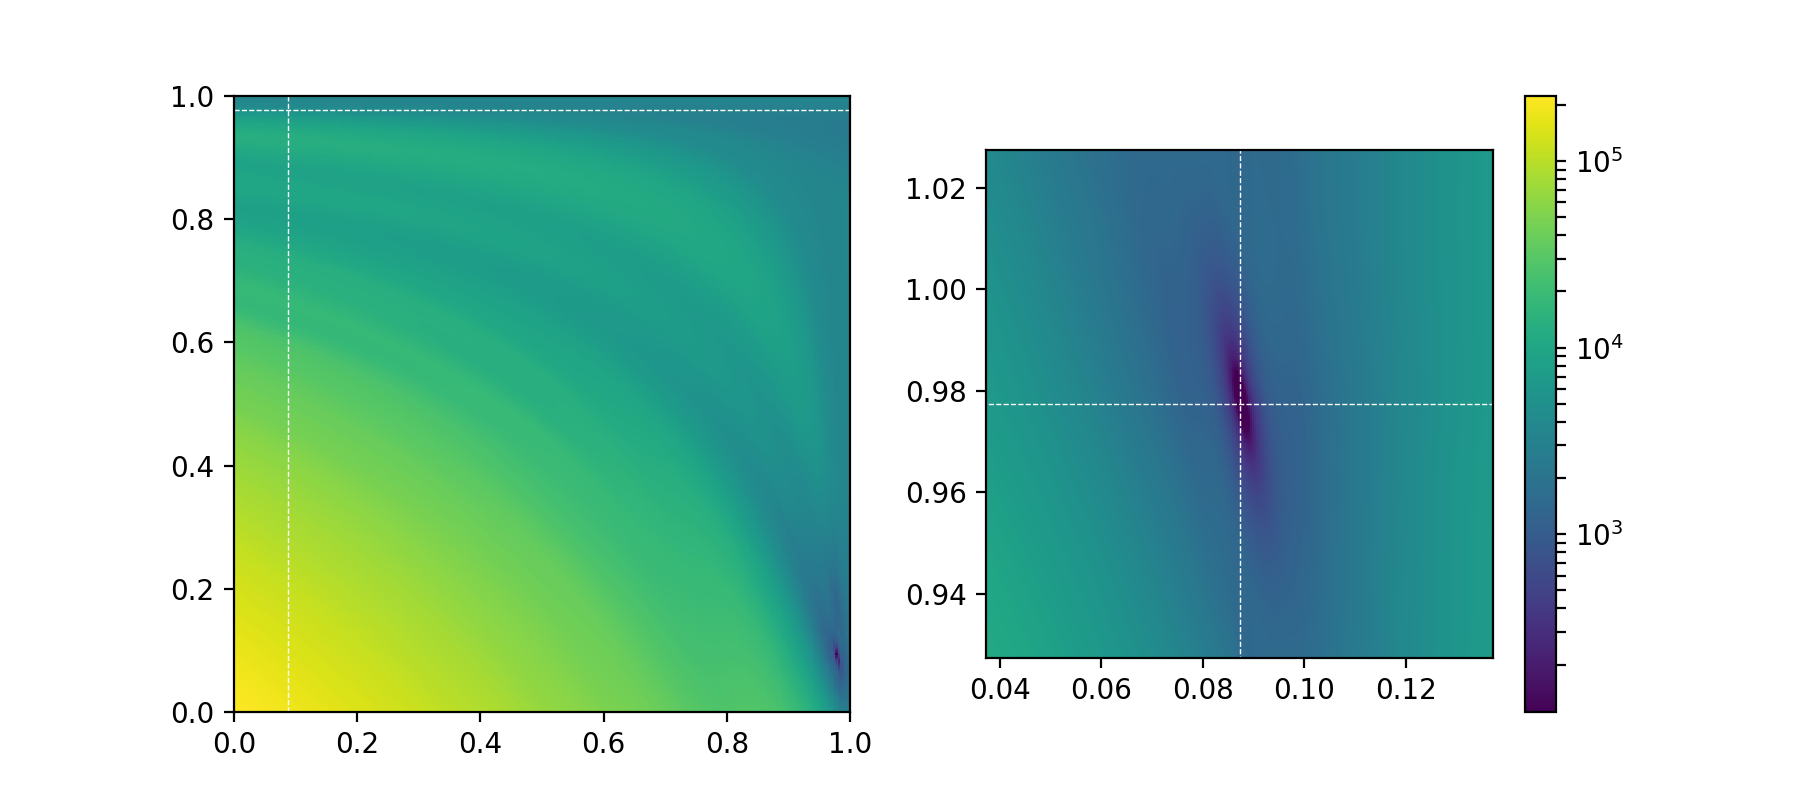

In [19]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plt.imshow(im, extent=[0, 1, 0, 1], origin='lower',
           norm=SymLogNorm(1, vmin=im.min(), vmax=im.max()))
plt.plot([params[1], params[1]], [0, 1], '--w', linewidth=.5)
plt.plot([0, 1], [params[2], params[2]], '--w', linewidth=.5)

plt.subplot(122)
ax = plt.imshow(im_narrow, extent=[params[1] - .05, params[1] + .05,
                              params[2] - .05, params[2] + .05],
           origin='lower', norm=SymLogNorm(1, vmin=im.min(), vmax=im.max()))
plt.plot([params[1], params[1]], [0, 2], '--w', linewidth=.5)
plt.plot([0, 1], [params[2], params[2]], '--w', linewidth=.5)
plt.xlim([params[1] - .05, params[1] + .05])
plt.ylim([params[2] - .05, params[2] + .05])

plt.colorbar()

The conclusion is that the minimum dip is just too narrow for this simple minimization method I chose.

I'll need to get better at giving initial conditions and/or explore the space better to fix this.

Alternatively, I could re-examine the scoring function, and see if there are more forgiving versions.